In [2]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn import preprocessing 
from sklearn import datasets
from IPython.display import Image
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pydotplus

%matplotlib inline

In [3]:
#讀取 clean_data
data = pd.read_csv('../result_data/clean_data.csv')

In [4]:
#找出不同型態index
num_cols = data.select_dtypes(include=['int64','float64'], exclude=['object','datetime64[ns]']).columns
object_cols = data.select_dtypes(include='object', exclude=['int64','float64','datetime64[ns]']).columns
num_col_index = []
object_col_index = []
for num_col in num_cols:
    num_col_index.append(list(data.columns).index(num_col))
for object_col in object_cols:
    object_col_index.append(list(data.columns).index(object_col))
object_col_index.remove(13)

In [5]:
#資料分類成不同型態
X_object = data.iloc[:, object_col_index]
X_num = data.iloc[:, num_col_index]
y = data.iloc[:, 13]

In [6]:
#X,y資料編號
y = y.astype('category').cat.codes
for num in X_object.columns:
    X_object[num] = X_object[num].astype('category').cat.codes
X = pd.concat([X_object,X_num],axis=1)

In [7]:
class_names = data['loan_status'].unique()
class_names.sort()
feature_names = list(X.columns)
X = X.values
y = y.values

In [8]:
#資料分成訓練、測試
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [9]:
#資料標準化
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
#利用隨機森林擬合訓練資料
rf0 = RandomForestClassifier(random_state = 0 ,oob_score=True,min_samples_split=1000,min_samples_leaf=3000,max_depth=10)
rf0.fit(X_train, y_train)
print ('oob_score =',rf0.oob_score_)

oob_score = 0.7905768558791658


In [63]:
# 利用 RFE 做欄位排名
names = feature_names
rfe = RFE(rf0, n_features_to_select=10 ,step=10)
fit = rfe.fit(X, y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 10
Selected Features: [ True  True  True False False False False False False False False False
 False False False False  True False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False  True  True  True
  True False]
Feature Ranking: [ 1  1  1  8  8  3  4 10  8  9  5  7  6  9 10 10  1  6  9  4  8  8  3  3
  3  1  3  4  2  9  8  6  9  6  5  7 10 10 10  9  3  5  4  2  4  6 10 10
  7  5  7  7  2  5  8  9  5  4  6  7  8  5  8  4  6 10 10  9  6  7  6  9
  9  2  7  4  7  5  5  3  3  5  8  7  6  4  3  4  2  3  1  2  2  1  1  1
  1  2]


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980650 entries, 0 to 980649
Data columns (total 99 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      980650 non-null  int64  
 1   funded_amnt                    980650 non-null  int64  
 2   funded_amnt_inv                980650 non-null  float64
 3   term                           980650 non-null  object 
 4   int_rate                       980650 non-null  float64
 5   installment                    980650 non-null  float64
 6   grade                          980650 non-null  object 
 7   sub_grade                      980650 non-null  object 
 8   emp_title                      980650 non-null  object 
 9   emp_length                     980650 non-null  object 
 10  home_ownership                 980650 non-null  object 
 11  annual_inc                     980650 non-null  float64
 12  verification_status           

In [12]:
#結合EPA & RFE 選取的欄位重做隨機森林訓練擬合
X_object = data.iloc[:, [3,7,72]]
X_num = data.iloc[:, [4,91,94,95,96,97]]
y = data.iloc[:, 13]

y = y.astype('category').cat.codes
for num in X_object.columns:
    X_object[num] = X_object[num].astype('category').cat.codes
X = pd.concat([X_object,X_num],axis=1)

class_names = data['loan_status'].unique()
class_names.sort()
feature_names = list(X.columns)

X = X.values
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rf0 = RandomForestClassifier(random_state = 0 ,oob_score=True,min_samples_split=1000,min_samples_leaf=3000,max_depth=10)
rf0.fit(X_train, y_train)
print ('oob_score =',rf0.oob_score_)

oob_score = 0.8047688130449621


In [194]:
#隨機森林參數篩選
param_test1 = {'min_samples_leaf':[500,1000,1500],'min_samples_split':[1000,1500,2000]}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(random_state = 0 ,n_estimators=100,max_depth=10), 
                       param_grid = param_test1,cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

({'min_samples_leaf': 500, 'min_samples_split': 1000}, 0.8050230673434828)

In [14]:
#測試資料預測結果
rf0 = RandomForestClassifier(n_estimators=100,min_samples_split=1000,min_samples_leaf=500,max_depth=10,random_state = 0 ,oob_score=True)
rf0.fit(X_train, y_train)
print ('oob_score =',rf0.oob_score_)
y_pred = rf0.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accurate = 0
for num in range(len(cm)):
    accurate += cm[num][num]
accurate = accurate/cm.sum()
print('Total_Accurate =',accurate)

oob_score = 0.8049836366924228
Total_Accurate = 0.8040324192476026


In [17]:
#做tree結果圖 % 儲存圖片
Estimators = rf0.estimators_
filename = 'tree.pdf'
dot_data = tree.export_graphviz(Estimators[0] , out_file=None,
                     feature_names=feature_names,
                     class_names=class_names,
                     filled=True, rounded=True,
                     special_characters=True,
                     impurity=False,rotate=True,
                     proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())
graph.write_pdf('../result_data/'+filename)


True

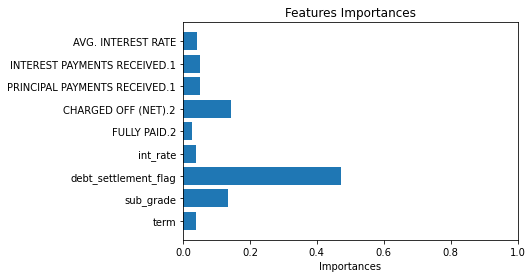

In [18]:
#畫欄位重要性圖
y_importances = rf0.feature_importances_
x_importances = feature_names
y_pos = np.arange(len(x_importances))
# 横向柱状图
plt.barh(y_pos, y_importances, align='center')
plt.yticks(y_pos, x_importances)
plt.xlabel('Importances')
plt.xlim(0,1)
plt.title('Features Importances')
plt.show()